# TP 2 : Computer Vision

## Part 2 : feature detection

In this part of the TP, we are going to look at the following feature detector :

- Harris corner detection

First, let us again load some packages and define some helper functions

(600, 800)

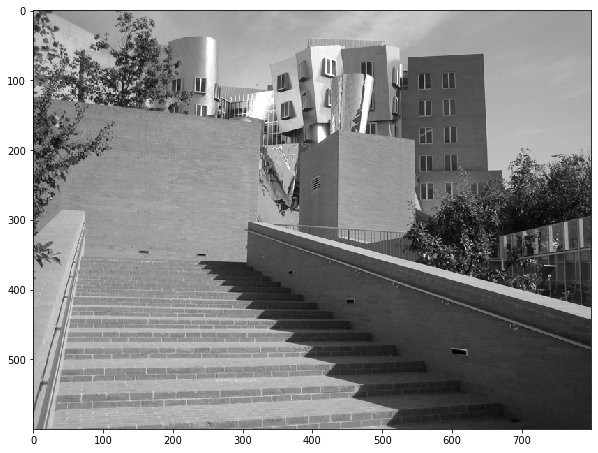

In [6]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color
from scipy import signal
from scipy.ndimage.morphology import binary_dilation

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

# this function annotates an image with coloured squares at the positions detected by the harris detector
def annotate_image(img_in, img_harris):
    
    img_harris_out = np.tile( np.expand_dims(img_in,axis=2), (1,1,3))
    block_size = 5
    struct_el = np.ones((block_size,block_size))
    # now annotate the image
    img_harris = binary_dilation(img_harris,struct_el)
    img_harris_out[img_harris>0,0] = 1.0
    img_harris_out[img_harris>0,1:3] = 0.0
    
        
    return img_harris_out


file_dir = 'images/'
file_name = 'mit'
file_ext = '.png'
img_gray,_ = read_image(file_dir+file_name+file_ext)
display_image(img_gray)
img_gray.shape

The goal of the Harris detector is to detect corners. The criterion used is the following : if we shift the image (spatially) in any direction, the underlying image should change values. In other words, we should be able to distinguish between the initial image and the shifted image. This is not true, for example, with constant images or edges; there is an ambiguity (see the lesson slides for more detail).

This criterion is formalised by associating the following matrix with __each pixel__ $p$ in the image :

$A = 
    \begin{bmatrix}
        \sum_{q \in \Psi_p} I_x(q)^2 & \sum_{q \in \Psi_p} I_x(q)I_y(q) \\
        \sum_{q \in \Psi_p} I_x(q)I_y(q) & \sum_{q \in \Psi_p} I_y(q)^2
    \end{bmatrix}
$

where $I_x$ is the $x$-direction component of image gradient, and similarly for $I_y$, and $\Psi_p$ is a small ''patch'' centred on $p$. A patch is a small image square.

Each pixel, therefore, contains a descriptor. The Harris detector consists in detecting the pixels whose descriptor verifies the following criterion :

$| \text{det}(A) - \alpha \text{trace}(A)^2 |  >k$

where det refers to the determinant of the matrix, and $k$ is a threshold. If this criterion is verified, then both the eigenvalues of the matrix are very large, which means that the two principal directions of local motion in the image lead to large changes in the image (which is what we were looking for). In fact, this does not correspond to __only__ corners, however corners do verify this criterion. 

For more precise details about this, again, see the slides.

We are going to implement this detector now.

Firstly, implement a function ``harris_feature`` which calculates the previous criterion for each pixel. You will have to implement the following steps :

- calculate the necessar gradients (you can use the ``np.gradient`` function) 
- create a filter to calculate the average value of the different gradients in a patch region. You should calculate these averages __before__ carrying out the two loops over the pixels, to avoid inefficient computation
- for each pixel, create the matrix $A$ and determine the Harris feature. For the matrix operations, you can use the ``np.linalg`` subpackage
- threshold the resulting image


Use the following parameters :

- patch_size = 7
- $\alpha$ = 0.04
- $k$ = 0.0002

In [0]:
from scipy import signal
def harris_feature(img,k):
    # FILL IN CODE HERE
    dx,dy=np.gradient(img_gray)
    img_harris_detect=np.zeros(img.shape)
    patch=np.ones([7,7])/49.0
    average_dx=(signal.convolve2d(dx**2,patch))
    average_dy=(signal.convolve2d(dy**2,patch))
    average_dx_dy=signal.convolve2d(dx*dy,patch)
    
    for i in range(img_gray.shape[0]):
      for j in range(img_gray.shape[1]):
        A=np.array([[average_dx[i,j],average_dx_dy[i,j]],[average_dx_dy[i,j],average_dy[i,j]]])
        if np.abs(np.linalg.det(A)-0.04*np.trace(A)**2)>k:
            img_harris_detect[i,j]=1
 
    return img_harris_detect
    

Now, display the resulting image. You can use the function ``annotate_image``. Note, this outputs and RGB image, where the detected points are annotated as blocks of a certain size (5 here), in red. To display this image, you need to put the pixel values back to the range $0, \dots, 255$

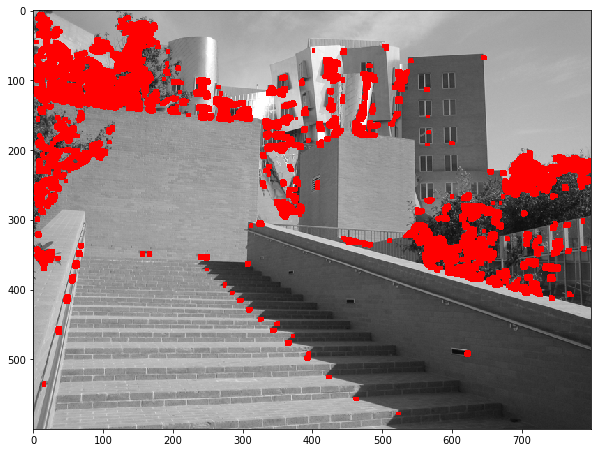

In [7]:
k = 0.00002
img_harris = harris_feature(img_gray,k)
display_image(255.0*annotate_image(img_gray,img_harris))

Now, you should observe something here: regions with many detections. Therefore, there is a second step : __non-maximum suppression__. This simply corresponds to removing detected pixels for which the Harris feature is not the maximum in a certain region.

Copy and paste the ``harris_feature`` code, and include non-maximum suppression before the output. For this, the following function can be useful:

- scipy.ndimage.maximum_filter()

In [0]:
from scipy.ndimage import maximum_filter

def harris_feature(img,k):
    dx,dy=np.gradient(img_gray)
    img_harris_detect=np.zeros(img.shape)
    patch=np.ones([7,7])/49.0
    average_dx=(signal.convolve2d(dx**2,patch))
    average_dy=(signal.convolve2d(dy**2,patch))
    average_dx_dy=signal.convolve2d(dx*dy,patch)
    for i in range(img_gray.shape[0]):
      for j in range(img_gray.shape[1]):
        A=np.array([[average_dx[i,j],average_dx_dy[i,j]],[average_dx_dy[i,j],average_dy[i,j]]])
        if np.abs(np.linalg.det(A)-0.04*np.trace(A)**2)>k:
            img_harris_detect[i,j]=np.abs(np.linalg.det(A)-0.04*np.trace(A)**2)
            
    img_harris_max=maximum_filter(img_harris_detect,7)
    img_harris_detect[np.where(img_harris_detect!=img_harris_max)]=0

    
    return img_harris_detect
    

Carry out the algorithm and display the result

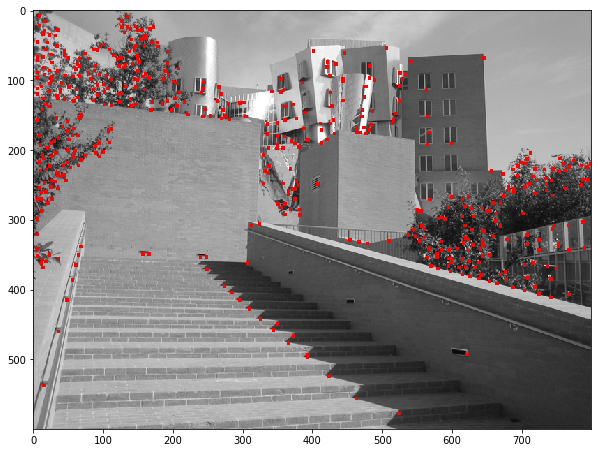

In [9]:
k = 0.00002
img_harris = harris_feature(img_gray,k)
display_image(255.0*annotate_image(img_gray,img_harris))

__Question__ Are there any corners missed ? Why do you think this is ? What solution could you propose (which we have seen in the first lesson) to improve the result.

__Answer__

**Image feature detection** is an important field of computer visual. Feature detection has been  widely  used  in  many  aspects,  such  as  image  matching,  objective  description,  object recognition etc. Human being identify objects and different people through the visual  system,  however,  this  simple  process  for  human  being  is  very  difficult  for  computers, first computers need to analyze image data, then extract accurate and stable feature  information  to  identify.  The  efficiency  of  feature  points  extracting  directly  affect precision rate and speed of image recognition. 

Harris  corner  detector  depends  on shifting a window in different directions and tracking the changes in the intensi-ties. Corners should give strong response, i.e. significant change, in all directions,whereas edges give strong response in a specific direction and flat regions do not give strong response at all.Although the Harris  corner  detector is great algorithm , but it still have following shortages: 

1_  The  quantity  and  quality  of  corner  extraction  largely  depends  on  thresholds  setting, if threshold is big, it will lose part of corners; if threshold is small, it will reduce the quantity of the corners, at the same time, the noise is more sensitive.  

2_ It is difficult to control the window size of the Gaussian smoothing function in process, if the window is too small, is influence by noise largely; if the window is too big, it will make the offset to the corner, and increase the computational amount. 

3_  If  using  infinite  smooth  Gaussian  function  as  filter  in  order  to  reduce  the  influence of noise, a lot of corner information is lost because of the smooth function.

4_ Harris corner detector provides a good stability against rotation. However,it is weak with respect to scale changes .


The **purposed  Solution** is to reduce image noise and aliasing artifacts through the convolution with a **Gaussian function**. This step was not included in the original proposal, but it improves the performance of the method.  In that case, the authors used Deriche’s recursive filter  for computing the derivatives of a Gaussian (with $\sigma=1$), so that the first two steps convolution with a Gaussian and gradient estimation are calculated in a single step.

The  selection  of  the  appropriate k need to consume a lot of time to debug and verify. To avoid this problem, we  need  to  find  a  response  function  which  doesn’t  affect  by  k .


**Harris-Laplacian** detector is a modified approach based on Harris cornerdetector and scale-space theory that has been developed to achieve scale invari-ance for the classical Harris detector . In this approach, the interest points aredetected using a scale adapted Harris function in a Laplacian scale-space.

**Harris-Affine** approach is another approach has been developed in to add affine invariance to Harris corner detector.  This approach detects the interestpoints in the same way as Harris-Laplacian does.  However,  the support regiondepends on the eigenvalues of the second moment matrix.

